In [1]:
# %matplotlib inline
# %matplotlib notebook
from dataGen import Gen
from multiscale_vae import vae
from train import slidingWindow, criterion, train, test
from Encoders import LongShort_TCVAE_Encoder
from Decoders import LongShort_TCVAE_Decoder
from vae import VariationalAutoencoder

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.distributions


import numpy as np
import matplotlib.pyplot as plt
import pprint

In [31]:
# all parameters for generating the time series should be configured in this cell
periode = 15 #days
step = 5 # mess interval in minutes
val = 100
n_channels = 3
effects = {
    "Pulse": {
        "occurances":0,
        "max_amplitude":2,   
        "interval":20
        },
    "Trend": {
        "occurances":1,
        "max_slope":0.005,
        "type":"mixed"
        },
    "Seasonality": {
        "occurances":2,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

### Init Model
latent_dims = 15
L = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# v = vae(n_channels, L, latent_dims)
v = VariationalAutoencoder(input_size = n_channels,
                           hidden_size = 10,
                           num_layers = 6,
                           latent_dims= latent_dims,
                           v_encoder = LongShort_TCVAE_Encoder,
                           v_decoder = LongShort_TCVAE_Decoder,
                           L = L,
                           first_kernel = 15)
opt = optim.Adam(v.parameters(), lr = 0.001)

{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [], 'channel': [], 'index': []},
 'Seasonality': {'amplitude': [14, 17],
                 'channel': [2, 0],
                 'frequency_per_week': [11.728727329002425, 8.701721596294608],
                 'phaseshift': [157, 22]},
 'Std_variation': {'amplitude': [], 'channel': [], 'interval': []},
 'Trend': {'channel': [2],
           'index': ['2023-03-15T15:30:00'],
           'slope': [-0.003366720944568409]}}


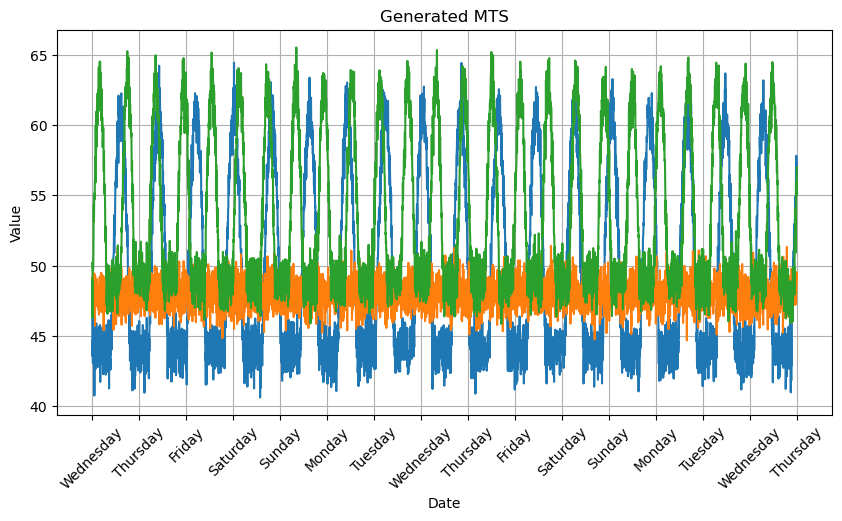

In [32]:
X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
# pprint.pprint(params)
pprint.pprint(e_params)
X.show()

In [33]:
# serie = torch.tensor(serie).float()
x = torch.FloatTensor(x)
n = x.shape[1]

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

# train_set = slidingWindow(train, 30)
# val_set = slidingWindow(val, 30)
# test_set = slidingWindow(test, 30)

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size=10,
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=10,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=10,
                        shuffle = False
                        )

In [34]:
print(v)

VariationalAutoencoder(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder(
      (cnn_layers): ModuleList(
        (0): Conv1d(3, 6, kernel_size=(2,), stride=(2,))
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(6, 12, kernel_size=(2,), stride=(2,))
        (4): ReLU(inplace=True)
        (5): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(12, 18, kernel_size=(2,), stride=(2,))
        (7): ReLU(inplace=True)
        (8): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Conv1d(18, 24, kernel_size=(2,), stride=(2,))
        (10): ReLU(inplace=True)
        (11): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): Conv1d(24, 30, kernel_size=(2,), stride=(2,))
        (13): ReLU(inplace=True)
        (14): BatchNorm1d(30, eps=1e-05, mo

In [35]:
for epoch in range(1, 100):
    train(v, train_data, criterion, opt, device, epoch)

Train Epoch: 1 [0/3356 (0%)]	Loss: 6768.904688
Train Epoch: 1 [1000/3356 (30%)]	Loss: 5658.058594
Train Epoch: 1 [2000/3356 (60%)]	Loss: 4873.166406
Train Epoch: 1 [3000/3356 (89%)]	Loss: 2481.562305
====> Epoch: 1 Average loss: 5161.3201
Train Epoch: 2 [0/3356 (0%)]	Loss: 1853.894336
Train Epoch: 2 [1000/3356 (30%)]	Loss: 900.576563
Train Epoch: 2 [2000/3356 (60%)]	Loss: 682.974463
Train Epoch: 2 [3000/3356 (89%)]	Loss: 185.597388
====> Epoch: 2 Average loss: 960.9624
Train Epoch: 3 [0/3356 (0%)]	Loss: 118.073743
Train Epoch: 3 [1000/3356 (30%)]	Loss: 52.266534
Train Epoch: 3 [2000/3356 (60%)]	Loss: 100.670746
Train Epoch: 3 [3000/3356 (89%)]	Loss: 21.728706
====> Epoch: 3 Average loss: 124.2730
Train Epoch: 4 [0/3356 (0%)]	Loss: 45.305173
Train Epoch: 4 [1000/3356 (30%)]	Loss: 56.095825
Train Epoch: 4 [2000/3356 (60%)]	Loss: 90.079236
Train Epoch: 4 [3000/3356 (89%)]	Loss: 18.660667
====> Epoch: 4 Average loss: 81.6904
Train Epoch: 5 [0/3356 (0%)]	Loss: 43.539737
Train Epoch: 5 [1000

Train Epoch: 36 [1000/3356 (30%)]	Loss: 45.850113
Train Epoch: 36 [2000/3356 (60%)]	Loss: 90.007990
Train Epoch: 36 [3000/3356 (89%)]	Loss: 15.372812
====> Epoch: 36 Average loss: 77.1485
Train Epoch: 37 [0/3356 (0%)]	Loss: 40.021744
Train Epoch: 37 [1000/3356 (30%)]	Loss: 45.623523
Train Epoch: 37 [2000/3356 (60%)]	Loss: 90.033551
Train Epoch: 37 [3000/3356 (89%)]	Loss: 15.324858
====> Epoch: 37 Average loss: 77.0006
Train Epoch: 38 [0/3356 (0%)]	Loss: 39.964749
Train Epoch: 38 [1000/3356 (30%)]	Loss: 45.648965
Train Epoch: 38 [2000/3356 (60%)]	Loss: 90.384900
Train Epoch: 38 [3000/3356 (89%)]	Loss: 15.348833
====> Epoch: 38 Average loss: 77.0809
Train Epoch: 39 [0/3356 (0%)]	Loss: 40.123856
Train Epoch: 39 [1000/3356 (30%)]	Loss: 45.843011
Train Epoch: 39 [2000/3356 (60%)]	Loss: 89.960571
Train Epoch: 39 [3000/3356 (89%)]	Loss: 15.172404
====> Epoch: 39 Average loss: 77.0438
Train Epoch: 40 [0/3356 (0%)]	Loss: 39.947113
Train Epoch: 40 [1000/3356 (30%)]	Loss: 45.690567
Train Epoch: 4

KeyboardInterrupt: 

In [28]:
def compare(dataset, model):
    model.eval()
    rec = []
    x = []
    with torch.no_grad():
        for i, data in enumerate(dataset):
            x_rec, mu, logvar = model(data)
            z = v.reparametrization_trick(mu, logvar)

            x.extend(data[:,:,0].detach().numpy())
            rec.extend(x_rec[:].detach().numpy())
        
    print(mu[-1, :], logvar[-1, :])
    plt.plot(rec, "r--")
    plt.plot(x[:], "b-")
    plt.ylim(0,100)
    plt.grid(True)
    
    return z[-1, :]

tensor([-0.0295,  0.0168,  0.0202, -0.0156, -0.0107,  0.0130,  0.0382, -0.0188,
        -0.0039,  0.0038,  0.0319,  0.0088, -0.0089,  0.0164, -0.0005, -0.0080,
        -0.0340,  0.0147, -0.0053, -0.0066,  0.0246, -0.0281, -0.0178,  0.0471,
         0.0462, -0.0578,  0.0220, -0.0318,  0.0406,  0.0419]) tensor([ 0.0003, -0.0747, -0.0039,  0.0121, -0.0228,  0.0210, -0.0267,  0.0225,
        -0.0192, -0.0073, -0.0152,  0.0437, -0.0007,  0.0409, -0.0011, -0.0176,
         0.0149,  0.0070,  0.0141,  0.0159,  0.0035, -0.0006, -0.0507, -0.0078,
         0.0433, -0.0072, -0.0211, -0.0029,  0.0300,  0.0425])


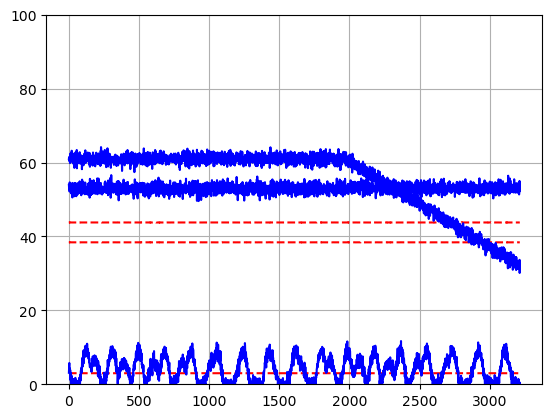

In [29]:
z = compare(train_data, v)

tensor([-0.1136,  0.0143, -1.1011,  0.0393, -0.0655,  0.0272, -0.2096, -0.1595,
         0.0021, -0.1218,  0.0981, -0.0614, -0.1264, -0.0803,  0.0688,  0.0212,
        -0.0161,  0.0224, -0.0133,  0.0168,  0.0162,  0.0270, -0.0078,  0.0236,
        -0.0321,  0.0129, -0.0111,  0.0385, -0.0191,  0.0197]) tensor([ 0.0263,  0.1067, -1.2306, -0.2132, -0.1941,  0.0117,  0.1161,  0.1298,
         0.0201, -0.1338,  0.1237, -0.1884, -0.0867, -0.1856,  0.0106, -0.0141,
        -0.0401, -0.0526, -0.0128,  0.0225, -0.0101, -0.0318,  0.0206, -0.0219,
         0.0173, -0.0157, -0.0102, -0.0295,  0.0090, -0.0406])


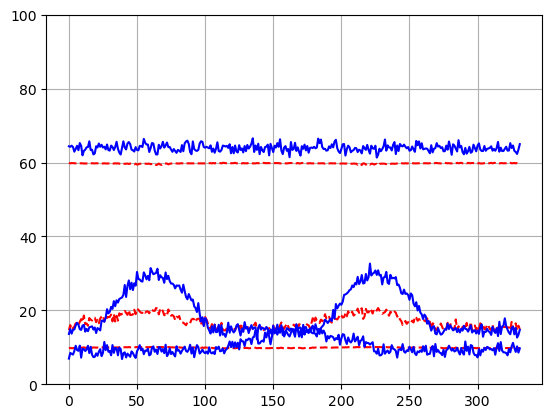

In [12]:
z = compare(test_data, v)

In [9]:
test(v, test_data, criterion, device)

====> Test set loss: 40.7919


1000


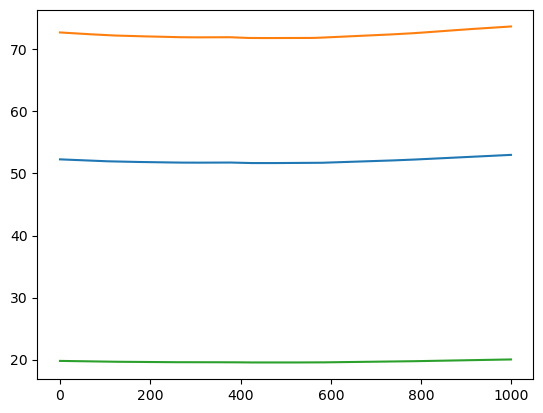

In [36]:
rec = []
for i in range(1000):
    z[16] = 0.01*i
    
    x_rec = v.decoder(z)

    rec.append(x_rec.detach().numpy())
print(len(rec))
plt.plot(rec)

In [37]:
z = np.arange(0.001,1, 0.01)
z

array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991])

In [40]:
# %matplotlib 
# import ipywidgets as widgets

# z = np.arange(16)
# @interact(z, np.arange(0.001,10, 0.01))
def experiment(z,z_num):
    rec = []
    for i in range(1000):
        z[z_num] = 0.01*i

        x_rec = v.decoder(z)

        rec.append(x_rec.detach().numpy())
    print(len(rec))
    plt.plot(rec)
    
# widgets.interact(experiment, z)

1000


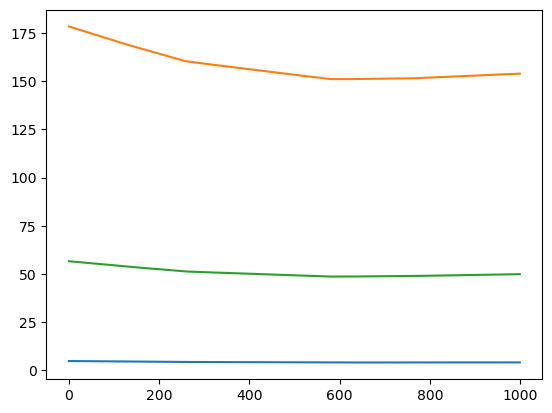

In [64]:
experiment(z,3)

In [ ]:
1) Pulse/ Rechteck
2) Trends (linear or not)
3) Periodicity
std. effects
5) coupling durch cov matrix
6) Noise
7) Effect of latent dim änderung, welche größe ist am besten  geeignet, soll latent_dim = n_channels sein? couploung durch hiarchie?
Modeling of interactions effects in die simulation hilft um die interpretation zu validieren, man kann die effecte aus der realen daten 
besser mathematisch verstehen
8) Short and long term effects durch die verschiedenen Convolutions weights"aktivierung von neuronen/ welche neuraonen sind mehr active in welche fälle"
idee is to know what layers capt long term effects and which layers capt short terms to be able to better interpret the data
9) also change the effects to be intern effects -> they happen on the level of mean and std rather than additif to the channels and let only be some random noise additif (y = x +epsilon)
all the rest (trends, seasonalities, pulses should happen on the level of mean and std)


Write and document all the steps I wanna do and make check list
try to make the data scales and dimention real (x axes represents tims -> days, hours, secs / are the seasonalities daily or weekly etc)

In [4]:
60/5

12.0

In [5]:
12*24

288

In [6]:
288*7

2016

In [7]:
2016*4

8064

In [8]:
60*24

1440

In [4]:
array = np.random.randint(10, size=(5,5))

In [5]:
array

array([[1, 8, 4, 1, 3],
       [6, 5, 3, 9, 6],
       [9, 1, 9, 4, 2],
       [6, 7, 8, 8, 9],
       [2, 0, 6, 7, 8]])

In [16]:
channels = [2,4]
start_idx = [1,2]
end_idx = [4,4]
[array[channels[i],start_idx[i]:end_idx[i]] for i in range(len(channels))]
# array[channels[,]start_idx]

[array([1, 9, 4]), array([6, 7])]

In [10]:
720/24

30.0

In [11]:
24*12*2


576